# Билет 4

In [1]:
import matplotlib.pyplot as plt
import torch

## Задание 3

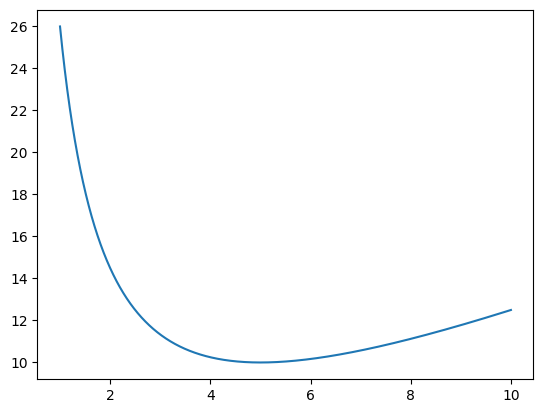

In [2]:
def f(x):
    return (x * x + 25) / x


START, END = 1, 10
EPS = 0.0000001
LR = 0.05

X = torch.arange(START, END + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Решу задачу с использованием алгоритма градиентного спуска, а для вычисления градиента буду использовать возможности PyTorch по автоматическому дифференцированию:

In [3]:
# initial_state = random.uniform(START, END)  # случайная инициализация - предпочтительно
initial_state = 9  # показательный пример
x = torch.tensor(initial_state, dtype=torch.float, requires_grad=True)

history = []
while True:
    history.append(x.detach().clone())
    y = f(x)
    y.backward()
    with torch.no_grad():
        x -= LR * x.grad
        if torch.abs(x - history[-1]) <= EPS:  # найден экстремум с необходимой точностью
            history.append(x.detach().clone())
            break
    x.grad.zero_()

В истории видно движение к искомой точке

[tensor(9.), tensor(8.6598), tensor(8.3324), tensor(8.0188), tensor(7.7201), tensor(7.4370), tensor(7.1707), tensor(6.9217), tensor(6.6908), tensor(6.4784), tensor(6.2847), tensor(6.1095), tensor(5.9525), tensor(5.8130), tensor(5.6903), tensor(5.5832), tensor(5.4904), tensor(5.4107), tensor(5.3427), tensor(5.2851), tensor(5.2365), tensor(5.1956), tensor(5.1615), tensor(5.1332), tensor(5.1096), tensor(5.0901), tensor(5.0740), tensor(5.0607), tensor(5.0497), tensor(5.0408), tensor(5.0334), tensor(5.0273), tensor(5.0224), tensor(5.0183), tensor(5.0150), tensor(5.0122), tensor(5.0100), tensor(5.0082), tensor(5.0067), tensor(5.0055), tensor(5.0045), tensor(5.0037), tensor(5.0030), tensor(5.0024), tensor(5.0020), tensor(5.0016), tensor(5.0013), tensor(5.0011), tensor(5.0009), tensor(5.0007), tensor(5.0006), tensor(5.0005), tensor(5.0004), tensor(5.0003), tensor(5.0003), tensor(5.0002), tensor(5.0002), tensor(5.0001), tensor(5.0001), tensor(5.0001), tensor(5.0001), tensor(5.0001), tensor(5.00

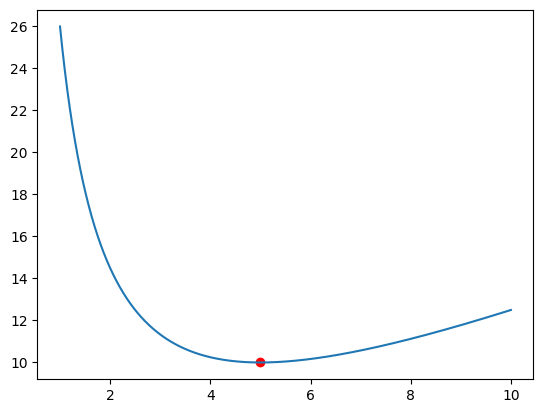

In [4]:
print(history[::10])
x = history[-1]
x, y = x.item(), f(x).item()
print(f"\nНайден локальный минимум: {x=:5f}, f(x)={y:5f}")
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");

Экстремум найден достаточно быстро и с хорошей точностью.

Также вместо ручной реализации градиентного спуска можно было использовать любой алгоритм оптимизации из PyTorch (Adam, SGD, Adagrad)

## Задание 2

In [5]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [7]:
insurance_df = pd.read_csv("../data/regression/insurance.csv")
print(insurance_df.shape)
insurance_df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Пропусков в данных нет:

In [8]:
na_stat = insurance_df.isna().sum()
na_stat[na_stat > 0]

Series([], dtype: int64)

В выборке присутствуют дубликаты - удалим их:

In [9]:
insurance_df[insurance_df.duplicated()].value_counts()

age  sex   bmi    children  smoker  region     charges  
19   male  30.59  0         no      northwest  1639.5631    1
dtype: int64

In [10]:
insurance_df = insurance_df.drop_duplicates()
insurance_df[insurance_df.duplicated()].value_counts()

Series([], dtype: int64)

In [11]:
print(insurance_df.shape)
insurance_df.head()

(1337, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
class InsuranceDataset(Dataset):

    def __init__(self, df, encoder=None, scaler=None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder()
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "charges"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = data.select_dtypes(object).columns, data.select_dtypes(np.number).columns
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

Разделила выборку на тренировочную и тестовую:

In [13]:
train_df, test_df = train_test_split(insurance_df, test_size=0.2)

train_dataset = InsuranceDataset(train_df)
test_dataset = InsuranceDataset(test_df, encoder=train_dataset.encoder, scaler=train_dataset.scaler)
len(train_dataset), len(test_dataset), train_dataset.num_features

(1069, 268, 6)

In [14]:
@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)
    return torch.flatten(torch.vstack(y_test)).cpu(), torch.flatten(torch.vstack(y_pred)).cpu()

In [15]:
class InsuranceRegression(nn.Module):

    def __init__(self, num_features):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(num_features, 256),  # входной слой
            nn.ReLU(True),  # функция активации
            nn.Dropout(),
            nn.Linear(256, 512),  # 1-ый скрытый слой
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 256),  # 2-ой скрытый слой
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 1),  # выходной слой
        )

    def forward(self, x):
        return self.regressor(x)

In [16]:
net = InsuranceRegression(train_dataset.num_features).to(DEVICE)
loss_fn = nn.MSELoss()  # среднеквадратичная ошибка
optimizer = optim.Adam(net.parameters(), lr=0.005)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

InsuranceRegression(
  (regressor): Sequential(
    (0): Linear(in_features=6, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [17]:
train_losses, train_r2s = [], []
test_losses, test_r2s = [], []
epochs = 200
for epoch in range(epochs):
    # =================== TRAIN ===================
    net.train()
    num_batches = len(train_dataloader)
    avg_loss, avg_r2 = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        r2 = metrics.r2_score(y.detach().cpu(), pred.detach().cpu())
        avg_loss += loss
        avg_r2 += r2
    train_loss, train_r2 = (avg_loss / num_batches).item(), avg_r2 / num_batches
    print(f"[Epoch {epoch + 1}/{epochs}] Train: loss={train_loss:.6f}, R^2={train_r2:.4f}")
    train_losses.append(train_loss)
    train_r2s.append(train_r2)

    # =================== TEST ===================
    y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
    test_loss, test_r2 = loss_fn(y_pred, y_true).item(), metrics.r2_score(y_true, y_pred)
    test_losses.append(test_loss)
    test_r2s.append(test_r2)

[Epoch 1/200] Train: loss=318843904.000000, R^2=-1.1889
[Epoch 2/200] Train: loss=270385440.000000, R^2=-0.8229
[Epoch 3/200] Train: loss=154880160.000000, R^2=-0.0528
[Epoch 4/200] Train: loss=133445888.000000, R^2=0.1221
[Epoch 5/200] Train: loss=106988272.000000, R^2=0.2824
[Epoch 6/200] Train: loss=92374024.000000, R^2=0.3676
[Epoch 7/200] Train: loss=75024064.000000, R^2=0.4999
[Epoch 8/200] Train: loss=60766884.000000, R^2=0.5744
[Epoch 9/200] Train: loss=54549940.000000, R^2=0.6239
[Epoch 10/200] Train: loss=49669604.000000, R^2=0.6723
[Epoch 11/200] Train: loss=40991156.000000, R^2=0.7262
[Epoch 12/200] Train: loss=40638708.000000, R^2=0.7238
[Epoch 13/200] Train: loss=39569108.000000, R^2=0.7402
[Epoch 14/200] Train: loss=36550652.000000, R^2=0.7543
[Epoch 15/200] Train: loss=33926140.000000, R^2=0.7702
[Epoch 16/200] Train: loss=37409940.000000, R^2=0.7480
[Epoch 17/200] Train: loss=33168352.000000, R^2=0.7464
[Epoch 18/200] Train: loss=36443384.000000, R^2=0.7454
[Epoch 19/2

Удалила первые 10 значений, чтобы график выглядел более разборчивым:

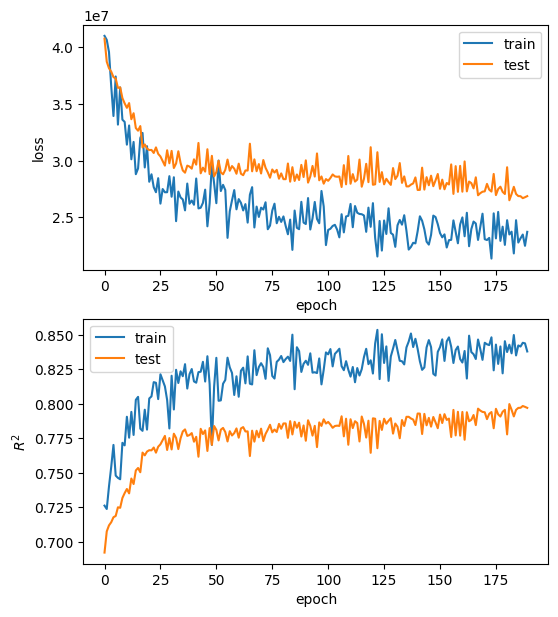

In [18]:
_, axes = plt.subplots(2, 1, figsize=(6, 7))
epochs = torch.arange(len(train_losses[10:]))

axes[0].plot(epochs, train_losses[10:])
axes[0].plot(epochs, test_losses[10:])
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_r2s[10:])
axes[1].plot(epochs, test_r2s[10:])
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("$R^2$")
axes[1].legend(["train", "test"]);

Немного других метрик:

In [19]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)

r2 = metrics.r2_score(y_true, y_pred)
mse = loss_fn(y_true, y_pred)
print(f"R^2: {r2:.6f}")
print(f"MSE: {loss_fn(y_true, y_pred):.6f}")
print(f"RMSE: {np.sqrt(mse):.6f}")
print(f"MAE: {metrics.mean_absolute_error(y_true, y_pred):.6f}")

R^2: 0.797074
MSE: 26865782.000000
RMSE: 5183.221191
MAE: 2835.115234


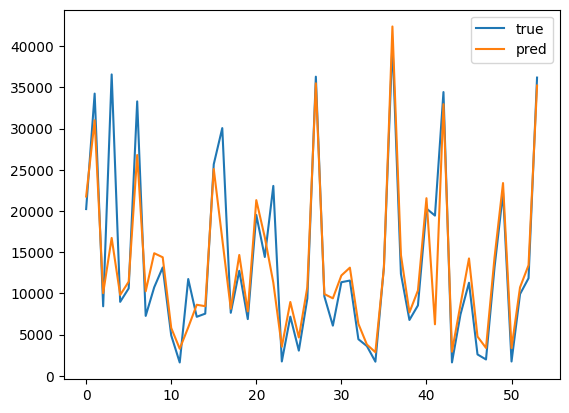

In [20]:
x = torch.arange(len(y_pred[::5]))
plt.plot(x, y_true[::5])
plt.plot(x, y_pred[::5])
plt.legend(["true", "pred"]);

Модель вышла неплохого качества - $R^2$ ~= 0.85 (близок к 1).